# Rank Simulator: Absolute Gaussian

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def max_gaussian_sampler(ranker, N, B, D):
    data = np.absolute(np.random.randn(N, B, D))
    score = ranker(data)
    idx = np.argmax(score, axis=1)
    chooser = np.expand_dims(np.eye(B)[idx], axis=1)
    data_max = (chooser @ data).squeeze()
    return data_max

def plotXY(x, y, label='y-x', xlabel='x', ylabel='y', figsize=(5, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(x, y, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim([-0.1 + min([0.0, x.min(), y.min()]), 0.1 + max(x.max(), y.max())])
    plt.ylim([-0.1 + min([0.0, x.min(), y.min()]), 0.1 + max(x.max(), y.max())])
    ax.grid()
    ax.legend()

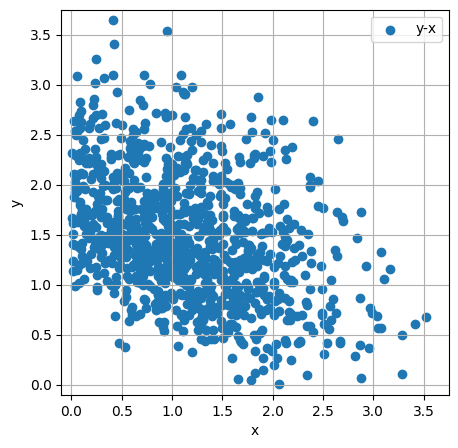

In [10]:
def getLinearRanker(K):
    def linearRanker(data):
        return data @ K
    return linearRanker
K, N, B, D = np.array([np.sin(np.pi/6), np.cos(np.pi/6)]), 1000, 5, 2
rst = max_gaussian_sampler(getLinearRanker(K), N, B, D)
plotXY(rst[:, 0], rst[:, 1])

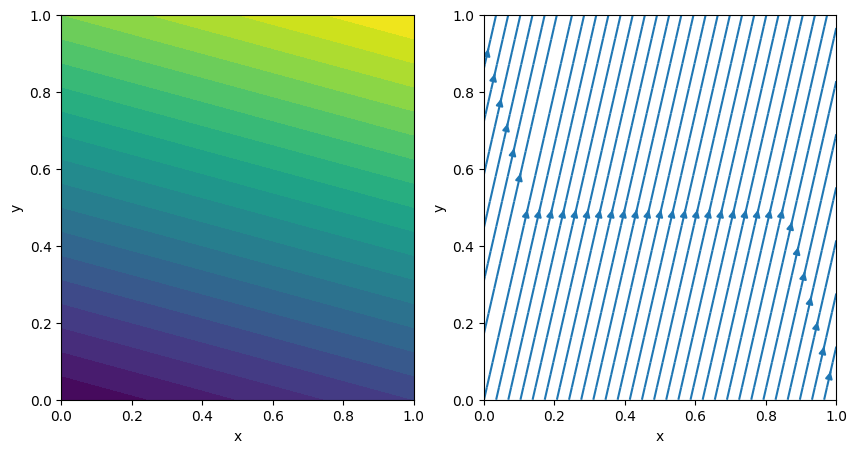

In [4]:
def partialDeviationEstimator(R, dx, dy):
    NY, NX = R.shape

    coeff_matrix = np.array([
        [-25/12, 4, -3, 4/3, -1/4],
        [-1/4, -5/6, 3/2, -1/2, 1/12],
        [1/12, -2/3, 0, 2/3, -1/12],
        [-1/12, 1/2, -3/2, 5/6, 1/4],
        [1/4, -4/3, 3, -4, 25/12],
    ])
    D = 5

    def getDevEstMatrix(N):
        coeff_idx_arr = (D-1)//2 * np.ones(N)
        coeff_idx_arr[:(D-1)//2] = np.arange((D-1)//2)
        coeff_idx_arr[-(D-1)//2:] = np.arange((D+1)//2, D)
        coeff_idx_arr = coeff_idx_arr.astype(int)
        A = np.zeros((N, N))
        for idx, coeff_idx in enumerate(coeff_idx_arr):
            A[idx, idx-coeff_idx:idx+D-coeff_idx] = coeff_matrix[coeff_idx]
        return A
    KX = getDevEstMatrix(NX).T / dx
    KY = getDevEstMatrix(NY) / dy
    DX = R @ KX
    DY = KY @ R
    return DX, DY

def plotScore(ranker, nx=10, ny=10, min_x=0, min_y=0, max_x=1, max_y=1, figsize=(10, 5), xlabel='x', ylabel='y', colorsteps=20):
    xrange = np.linspace(min_x, max_x, nx)
    yrange = np.linspace(min_y, max_y, ny)
    X, Y = np.meshgrid(xrange, yrange)
    dx, dy = xrange[1]-xrange[0], yrange[1]-yrange[0]
    R = ranker(X, Y)
    DX, DY = partialDeviationEstimator(R, dx, dy)

    fig, ax = plt.subplots(1, 2, figsize=figsize)
    ax[0].contourf(X, Y, R, colorsteps)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)

    ax[1].streamplot(X, Y, DX, DY)
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel(ylabel)

def getLinearRanker(a = 0.5, b = 0.5):
    def linearRanker(X, Y):
        return a * X + b * Y
    return linearRanker

plotScore(getLinearRanker(0.2, 0.8))

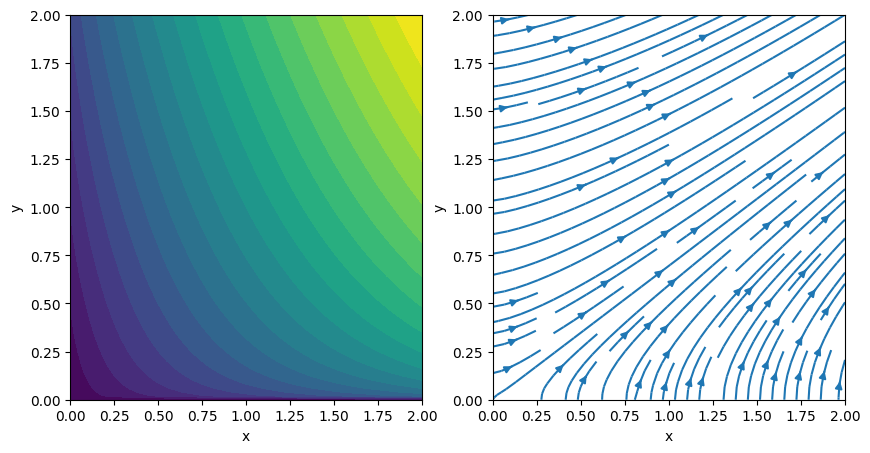

In [5]:
def getPowerRanker(p=0.8, a=0.8, b=0.2):
    def powerRanker(X, Y):
        return a * np.power(X, p) * np.power(Y, 1-p) + b * Y
    return powerRanker
        
plotScore(getPowerRanker(), max_x=2, max_y=2, nx=100, ny=100)

## Abstract Gaussion

In [6]:
def plotxy(x, y, label='y-x', xlabel='x', ylabel='y', figsize=(5, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax.plot(x, y, label=label)
    ax.grid()
    ax.legend()

初始分布的CDF为$P_0(x, y)$, PDF为$p_0(x, y)$, 每次从中采样$n$个点，从中选择$r(x, y)$最大的点。
求解 $n$ 选 1 之后的分布，更确切的是分布的PDF： $p_n(x, y) = \frac{\partial^2 P_n(x, y)}{\partial X \partial Y}$。

$$
\begin{aligned}
\mathbb{P}\{r(X, Y) \le r(x, y)\} =& - \mathbb{P}\{X \le x, Y \le y\} + \mathbb{P}\{X \le x, r(X, Y) \le r(x, y)\} + \mathbb{P}\{Y \le y, r(X, Y) \le r(x, y)\}\\
\mathbb{P}\{X \le x, Y \le y\} =& \mathbb{P}\{X \le x, r(X, Y) \le r(x, y)\} + \mathbb{P}\{Y \le y, r(X, Y) \le r(x, y) \} - \mathbb{P}\{r(X, Y) \le r(x, y)\} \\
=& \mathbb{P}(X \le x, R \le r) + \mathbb{P}(Y \le y, R \le r) - \mathbb{P}(R \le r)
\end{aligned}
$$

$$
\begin{aligned}
F(r(x, y)) =& \mathbb{P}(R \le r(x, y)) \\
\frac{\partial^2 F(r(x, y))}{\partial x \partial y} =& \frac{\partial F}{\partial r} \cdot \frac{\partial^2 r} {\partial x \partial y}
+ \frac{d^2 F}{d r^2} \cdot \frac{\partial r}{\partial x} \cdot \frac{\partial r}{\partial y}\\
F(r) =& P^n_0(r)\\
F'(r) =& n P^{n-1}_0(r) p_0(r)\\
F''(r) =& n P^{n-1}_0(r) p'_0(r) + n(n-1)P^{n-2}_0(r) p^2_0(r)\\
\frac{\partial^2 F(r(x, y))}{\partial x \partial y} =& r_{xy} [n P^{n-1}_0(r) p_0(r)] + r_x r_y [n P^{n-1}_0(r) p'_0(r) + n(n-1)P^{n-2}_0(r) p^2_0(r)]\\
\end{aligned}

$$
\begin{aligned}
P\{X \le x \vert R = r\} =& P_0\{X \le x \vert R = r\} = \frac{P_0\{X \le x, R = r\}}{P_0\{R = r\}} = \frac{P_0\{X \le x, R = r\}}{p_0(r)}\\
G(x, r(x, y)) = \mathbb{P}\{X \le x, R \le r\} =& \int^r_0 \mathbb{P}\{X \le x, R = r\} dr\\
=& \int^r_0 \mathbb{P}\{R = r\} \mathbb{P}\{X \le x \vert R = r\} dr \\
=& \int^r_0 p(r) {P_0\{X \le x \vert R = r\}} dr\\
=& \int^r_0 p(r) \frac{P_0\{X \le x, R = r\}}{p_0(r)} dr\\
=& \int^r_0 n P^{n-1}_0(r) p_0(r) \cdot \frac{P_0\{X \le x, R = r\}}{p_0(r)} dr\\
=& \int^r_0 n P^{n-1}_0(r) \cdot P_0\{X \le x, R = r\} dr\\
\end{aligned}
$$

$$
\begin{aligned}
\frac{\partial^2 G(x, r(x, y))}{\partial x \partial y} =&
\frac{\partial G(x, r)}{\partial r} \cdot \frac{\partial^2 r(x, y)}{\partial x \partial y}
+ \frac{\partial^2 G(x, r)}{\partial r^2} \cdot \frac{\partial r(x, y)}{\partial x} \cdot \frac{\partial r(x, y)}{\partial y}
+ \frac{\partial^2 G(x, r)}{\partial r \partial x} \cdot \frac{\partial r}{\partial y} \\
=& r''_{xy} \frac{\partial G(x, r)}{\partial r} + r'_x r'_y \frac{\partial^2 G(x, r)}{\partial r^2} + r'_y \frac{\partial^2 G(x, r)}{\partial r \partial x} \\
=& r''_{xy} \bigg[n P^{n-1}_0(r) P_0(X \le x, R = r) \bigg] + r'_y \bigg[n P^{n-1}_0(r) p_0(x, r) \bigg] \\
&+ r'_x r'_y \bigg[ n(n-1)P^{n-2}_0(r) p_0(r) \cdot P_0(X \le x, R=r) + nP^{n-1}_0(r) \cdot \frac{\partial P_0(X \le x, R = r)}{\partial r}\bigg]\\
\end{aligned}
$$

$$
\begin{aligned}
H(y, r(x, y)) =& \mathbb{P}\{Y \le y, R \le r\} \\
=& \int^r_0 n P^{n-1}_0(r) \cdot P_0\{Y \le y, R = r\} dr\\
\frac{\partial^2 H(y, r(x, y))}{\partial x \partial y} =&
\frac{\partial H(y, r)}{\partial r} \cdot \frac{\partial^2 r(x, y)}{\partial x \partial y}
+ \frac{\partial^2 H(y, r)}{\partial r^2} \cdot \frac{\partial r(x, y)}{\partial x} \cdot \frac{\partial r(x, y)}{\partial y}
+ \frac{\partial^2 H(y, r)}{\partial r \partial y} \cdot \frac{\partial r}{\partial x} \\
=& r''_{xy} \frac{\partial H(y, r)}{\partial r} + r'_x r'_y \frac{\partial^2 H(y, r)}{\partial r^2} + r'_x \frac{\partial^2 H(y, r)}{\partial r \partial y} \\
=& r''_{xy} \bigg[n P^{n-1}_0(r) P_0(Y \le y, R = r) \bigg] + r'_x \bigg[n P^{n-1}_0(r) p_0(y, r) \bigg] \\
&+ r'_x r'_y \bigg[ n(n-1)P^{n-2}_0(r) p_0(r) \cdot P_0(Y \le y, R=r) + nP^{n-1}_0(r) \cdot \frac{\partial P_0(Y \le y, R = r)}{\partial r}\bigg]\\
\end{aligned}
$$

## 验证-AbsGaussian Distribution

设标准正太分布的CDF函数为 $\Phi(r)$，PDF函数为 $\phi(r)$, PDF的导数为 $-r \phi(r)$。
$$
\begin{aligned}
& Z_1 \sim \mathcal{N}(0, 1), X = |Z_1|;\\
& Z_2 \sim \mathcal{N}(0, 1), Y = |Z_2|;\\
P_0(x) =& \mathbb{P}(0 \le X \le x) = \mathbb{P}(-x \le Z_1 \le x) = 2\int^x_{-\infty} p(z_1) d z_1 - 1 = 2 \Phi(x) - 1,\quad p_0(x) = 2\phi(x); \\
P_0(y) =& \mathbb{P}(0 \le Y \le y) = \mathbb{P}(-x \le Z_2 \le x) = 2\int^y_{-\infty} p(z_1) d z_1 - 1 = 2 \Phi(y) - 1,\quad p_0(y) = 2\phi(y); \\
& R = a X + b Y, a^2 + b^2 = 1, \\

P_0(r) =& \mathbb{P}(R \le r) = \mathbb{P}(ax + by \le r) = \int^{\frac{r}{b}}_0 \int^{\frac{r-by}{a}}_{0} p_0(x) p_0(y) dx dy \\
=& \int^{\frac{r}{b}}_0 P_0\bigg(x = \frac{r-by}{a}\bigg) \cdot 2\phi(y) d y \\
=& \int^{\frac{r}{b}}_0 \bigg[2\Phi\bigg(\frac{r-by}{a}\bigg) - 1\bigg] \cdot 2\phi(y) d y \\

p_0(r) =& \frac{1}{b} \cdot \bigg[2\Phi\bigg(\frac{r-by}{a}\bigg) - 1\bigg] \cdot 2\phi(y) \bigg\vert_{y = \frac{r}{b}}
+ \int^{\frac{r}{b}}_0 \frac{4}{a} \phi\bigg( \frac{r - by}{a} \bigg) \phi(y) d y\\
=& \frac{1}{b} \cdot \bigg[2\Phi(0) - 1\bigg] \cdot 2\phi\bigg(\frac{r}{b}\bigg) 
+ \int^{\frac{r}{b}}_0 \frac{4}{a} \phi\bigg( \frac{r - by}{a} \bigg) \phi(y) d y\\
=& \int^{\frac{r}{b}}_0 \frac{4}{a} \phi\bigg( \frac{r - by}{a} \bigg) \phi(y) d y\\
=& \int^{\frac{r}{b}}_0 \frac{4}{a \cdot 2 \pi} \exp\bigg( -\frac{(r - by)^2}{2a^2} \bigg) \exp\bigg(-\frac{y^2}{2}\bigg) d y\\
=& \int^{\frac{r}{b}}_0 \frac{4}{a \cdot 2 \pi} \exp\bigg( -\frac{r^2 - 2rby + b^2y^2 + a^2 y^2}{2a^2} \bigg) d y\\
=& \int^{\frac{r}{b}}_0 \frac{4}{a \cdot 2 \pi} \exp\bigg( -\frac{a^2r^2 + (br - y)^2}{2a^2} \bigg) d y, \quad(a^2 + b^2 = 1)\\
=& \frac{4}{a\sqrt{2\pi}} \exp\bigg(-\frac{r^2}{2}\bigg)\int^{\frac{r}{b}}_0 \frac{1}{\sqrt{2 \pi}} \exp\bigg( -\frac{(y - br)^2}{2a^2} \bigg) d y\\
=& \frac{4}{\sqrt{2\pi}} \exp\bigg(-\frac{r^2}{2}\bigg)\int^{\frac{r}{b}}_0 \frac{1}{\sqrt{2 \pi} a} \exp\bigg( -\frac{(y - br)^2}{2a^2} \bigg) d y\\
=& 4\phi(r) \bigg[\Phi\bigg(\frac{a}{b}r\bigg) + \Phi\bigg(-\frac{b}{a} r\bigg)\bigg] \\
=& 4\phi(r) \bigg[\Phi\bigg(\frac{a}{b}r\bigg) + \Phi\bigg(\frac{b}{a} r\bigg) - 1\bigg] \\
p'_0(r) =& 4\phi'(r) \bigg[\Phi\bigg(\frac{a}{b}r\bigg) + \Phi\bigg(\frac{b}{a} r\bigg) - 1\bigg]
+ 4\phi(r) \bigg[\frac{a}{b} \cdot \phi\bigg(\frac{a}{b}r\bigg) + \frac{b}{a}\phi\bigg(\frac{b}{a} r\bigg)\bigg] \\
=& -4 r \phi(r) \bigg[\Phi\bigg(\frac{a}{b}r\bigg) + \Phi\bigg(\frac{b}{a} r\bigg) - 1\bigg]
+ 4\phi(r) \bigg[\frac{a}{b} \cdot \phi\bigg(\frac{a}{b}r\bigg) + \frac{b}{a}\phi\bigg(\frac{b}{a} r\bigg)\bigg] \\
=& -4 r p_0(r) + 4\phi(r) \bigg[\frac{a}{b} \cdot \phi\bigg(\frac{a}{b}r\bigg) + \frac{b}{a}\phi\bigg(\frac{b}{a} r\bigg)\bigg] \\
\end{aligned}
$$

### 验证公式$P_0(r)$、$p_0(r)$

In [3]:
import numpy as np
from scipy.stats import norm

def rungeIntegration(h, N, x0, y0, f):
    x = [x0,]
    y = [y0,]
    xt, yt = x0, y0
    for i in range(1, N):
        K1 = f(xt, yt)
        K2 = f(xt, yt + h/2 * K1)
        K3 = f(xt + h/2, yt + h/2 * K2)
        K4 = f(xt + h, yt + h * K3)
        xt += h
        yt = yt + h * (K1/6 + K2*2/6 + K3*2/6 + K4/6)
        x.append(xt)
        y.append(yt)
    return np.array(x), np.array(y)

Er-runge = 1.0899305793441827
Er-data = 1.0998226408084146
Error MSE(runge_Pr, data_Pr) = 1.7601641761627933e-05


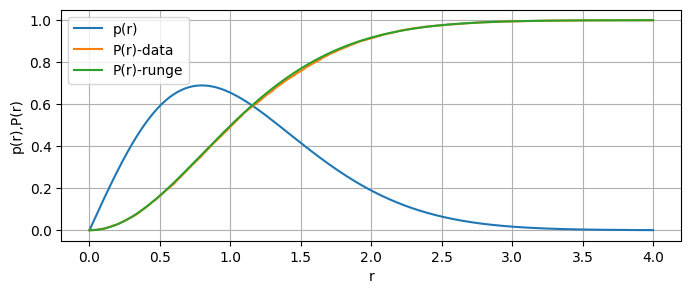

In [128]:
import numpy as np
from scipy.stats import norm

theta = np.pi/6
a, b = np.sin(theta), np.cos(theta)
k = np.array([a, b])
N, D = 10000, 2
data = np.absolute(np.random.randn(N, D))
data_r = data @ k

f = lambda x, y: 4*norm.pdf(x)*(norm.cdf(a/b*x) + norm.cdf(b/a*x)-1)

r = np.linspace(0, 4, N)
pr = f(r, 0.0)
h = r[1] - r[0]

runge_r, runge_Pr = rungeIntegration(h, N, 0.0, 0.0, f)
runge_r_Er, runge_Er = rungeIntegration(h, 2*N, 0.0, 0.0, lambda x, y: x*f(x, y))
runge_pr = f(runge_r, 0.0)

data_Pr = []
for tmp in runge_r:
    data_Pr.append((data_r < tmp).sum()/N)

print("Er-runge =", runge_Er[-1])
print("Er-data =", data_r.mean())
print("Error MSE(runge_Pr, data_Pr) =", ((data_Pr - runge_Pr)**2).mean())

fig, ax = plt.subplots(figsize=(8, 3))
#ax.scatter(data_r, np.zeros_like(data_r), label='r-sample', )
ax.plot(r, pr, label='p(r)')
ax.plot(runge_r, data_Pr, label='P(r)-data')
ax.plot(runge_r, runge_Pr, label='P(r)-runge')
plt.xlabel('r')
plt.ylabel('p(r),P(r)')
ax.grid()
ax.legend()

max 5->1: Er-data = 1.847017469630402
max 5->1: Er-runge = 1.8466479067201935
Error MSE(runge_P5r, data_P5r) = 7.071552404948049e-06


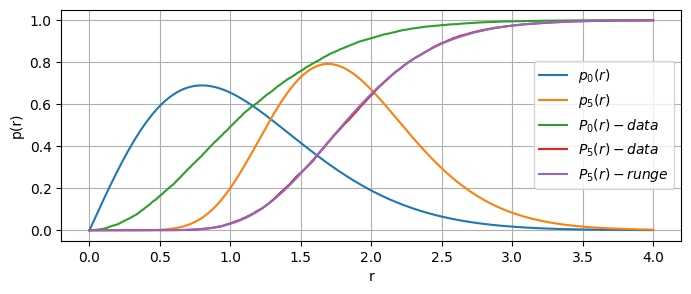

In [130]:
theta = np.pi/6
a, b = np.sin(theta), np.cos(theta)
K, N, B, D = np.array([a, b]), 10000, 5, 2
data_max = max_gaussian_sampler(getLinearRanker(K), N, B, D)
data_max_r = data_max @ K

data_max_Pr = []
for tmp in runge_r:
    data_max_Pr.append((data_max_r < tmp).sum()/N)

r0_map, P0r_map = rungeIntegration(h/2, N*4, 0.0, 0.0, lambda x, y: 4*norm.pdf(x)*(norm.cdf(a/b*x) + norm.cdf(b/a*x)-1))

def f_P5r(r, Pr):
    p0r = 4*norm.pdf(r)*(norm.cdf(a/b*r) + norm.cdf(b/a*r)-1)
    P0r = P0r_map[np.where((r0_map > r-0.1*h) & (r0_map < r+0.1*h))][0]
    return 5 * P0r**4 * p0r

def f_E5r(r, Pr):
    p0r = 4*norm.pdf(r)*(norm.cdf(a/b*r) + norm.cdf(b/a*r)-1)
    P0r = P0r_map[np.where((r0_map > r-0.1*h) & (r0_map < r+0.1*h))][0]
    return 5 * P0r**4 * p0r * r

runge_P5r = runge_Pr**5
_, runge_E5r = rungeIntegration(h, 2*N, 0.0, 0.0, f_E5r)
print("max 5->1: Er-data =", data_max_r.mean())
print("max 5->1: Er-runge =", runge_E5r[-1])
print("Error MSE(runge_P5r, data_P5r) =", ((data_max_Pr - runge_P5r)**2).mean())

fig, ax = plt.subplots(figsize=(8, 3))
# ax.scatter(data_max_r, np.zeros_like(data_max_r), label='max-r-sample')
ax.plot(r, pr, label=r'$p_0(r)$')
ax.plot(runge_r, 5*runge_Pr**4 * runge_pr, label=r'$p_5(r)$')
ax.plot(r, data_Pr, label=r'$P_0(r)-data$')
ax.plot(runge_r, data_max_Pr, label=r'$P_5(r)-data$')
ax.plot(runge_r, runge_P5r, label=r'$P_5(r)-runge$')
plt.xlabel('r')
plt.ylabel('p(r)')
ax.grid()
ax.legend()

### 继续推导

$$
\begin{aligned}
P_0(X \le x, R \le r) =& \int^x_{0} \int^{\frac{r - ax}{b}}_{0} 4 \phi(x) \phi(y) dy dx \\
P_0(X \le x, R = r) =& \frac{4}{b} \int^x_{0} \phi(x) \phi\bigg(\ \frac{r - ax}{b} \bigg) dx \\
=& \frac{4}{b} \int^x_{0} \frac{1}{\sqrt{2\pi}} \exp\bigg\{-\frac{x^2}{2}\bigg\} \cdot \frac{1}{\sqrt{2\pi}} \exp\bigg\{-\frac{(r - ax)^2}{2b^2}\bigg\} dx \\
=& \frac{4}{b} \int^x_{0} \frac{1}{2\pi} \exp\bigg\{-\frac{b^2x^2 + a^2 x^2 - 2arx + r^2}{2b^2}\bigg\} dx \\ 
=& \frac{4}{b} \int^x_{0} \frac{1}{2\pi} \exp\bigg\{-\frac{x^2 - 2arx + a^2 r^2 + b^2 r^2}{2b^2}\bigg\} dx \\ 
=& \frac{4}{b} \int^x_{0} \frac{1}{2\pi} \exp\bigg\{-\frac{(x - ar)^2}{2b^2}\bigg\} \cdot \exp\bigg\{-\frac{r^2}{2}\bigg\} dx\\
=& 4 \phi(r) \int^x_{0} \frac{1}{\sqrt{2\pi} b} \exp\bigg\{-\frac{(x - ar)^2}{2b^2}\bigg\} dx\\
=& 4 \phi(r) \bigg[ \Phi\bigg(\frac{x - ar}{b}\bigg) - \Phi\bigg(-\frac{ar}{b}\bigg) \bigg]\\
=& 4 \phi(r) \bigg[ \Phi\bigg(\frac{x - ar}{b}\bigg) + \Phi\bigg(\frac{ar}{b}\bigg) - 1 \bigg]\\
p_0(x, r) =& \frac{4}{b} \phi(r) \phi\bigg(\frac{x - ar}{b}\bigg) \\
\frac{\partial P_0(X \le x, R = r)}{\partial r} 
=& 4 \phi'(r) \bigg[ \Phi\bigg(\frac{x - ar}{b}\bigg) + \Phi\bigg(\frac{ar}{b}\bigg) - 1 \bigg]
+4 \phi(r) \bigg[ -\frac{a}{b}\phi\bigg(\frac{x - ar}{b}\bigg) + \frac{a}{b}\phi\bigg(\frac{ar}{b}\bigg) \bigg]\\
=& -4 r\phi(r)\bigg[ \Phi\bigg(\frac{x - ar}{b}\bigg) + \Phi\bigg(\frac{ar}{b}\bigg) - 1 \bigg]
- \frac{4a}{b} \phi(r) \phi\bigg(\frac{x - ar}{b}\bigg) + \frac{4a}{b} \phi(r) \phi\bigg(\frac{ar}{b}\bigg) \\
=& - r P_0(X \le x, R = r) - a p_0(x, r) + \frac{4a}{b} \phi(r) \phi\bigg(\frac{ar}{b}\bigg) \\
\end{aligned}
$$

$$
\begin{aligned}
P_0(Y \le y, R \le r) =& \int^y_{0} \int^{\frac{r - by}{a}}_{0} 4 \phi(x) \phi(y) dx dy \\
P_0(Y \le y, R = r) =& 4 \phi(r) \bigg[ \Phi\bigg(\frac{y - br}{a}\bigg) + \Phi\bigg(\frac{br}{a}\bigg) - 1 \bigg]\\
p_0(y, r) =& \frac{4}{a} \phi(r) \phi\bigg(\frac{y - br}{a}\bigg) \\
\frac{\partial P_0(Y \le y, R = r)}{\partial r} =& - r P_0(Y \le y, R = r) - b p_0(y, r) + \frac{4b}{a} \phi(r) \phi\bigg(\frac{br}{a}\bigg) \\
\end{aligned}
$$

$$
\begin{aligned}
p_n(x, y) =& -f_n(x, y) + g_n(x, y) + h_n(x, y) \\
f_n(x, y) =& r''_{xy} [n P^{n-1}_0(r) p_0(r)] + r'_x r'_y [n P^{n-1}_0(r) p'_0(r) + n(n-1)P^{n-2}_0(r) p^2_0(r)]\\
g_n(x, y) =& r''_{xy} \bigg[n P^{n-1}_0(r) P_0(X \le x, R = r) \bigg] + r'_y \bigg[n P^{n-1}_0(r) p_0(x, r) \bigg] \\
&+ r'_x r'_y \bigg[ n(n-1)P^{n-2}_0(r) p_0(r) \cdot P_0(X \le x, R=r) + nP^{n-1}_0(r) \cdot \frac{\partial P_0(X \le x, R = r)}{\partial r}\bigg]\\
h_n(x, y) =& r''_{xy} \bigg[n P^{n-1}_0(r) P_0(Y \le y, R = r) \bigg] + r'_x \bigg[n P^{n-1}_0(r) p_0(y, r) \bigg] \\
&+ r'_x r'_y \bigg[ n(n-1)P^{n-2}_0(r) p_0(r) \cdot P_0(Y \le y, R=r) + nP^{n-1}_0(r) \cdot \frac{\partial P_0(Y \le y, R = r)}{\partial r}\bigg]\\
\end{aligned}
$$

$$
\begin{aligned}
p_n(x, y) =& r''_{xy}nP^{n-1}_0(r)[P_0(X \le x, R=r) + P_0(Y \le y, R = r) - p_0(r)] \\
&+ r'_x r'_y n P^{n-1}_{0}(r) \bigg[\frac{\partial P_0(X \le x, R = r)}{\partial r} + \frac{\partial P_0(Y \le y, R = r)}{\partial r} - p'_0(r)\bigg] \\
&+ r'_x r'_y n(n-1) P^{n-2}_{0}(r) [p_0(r) P_0(X \le x, R = r) + p_0(r) P_0(Y \le y, R = r) - p'_0(r)]\\
&+ r'_x n P^{n-1}_0(r) p_0(y, r) + r'_y n P^{n-1}_0(r) p_0(x, r)
\end{aligned}
$$

$$
\begin{aligned}
F(x, y, r) =& P_0(X \ge x, Y \ge y, R \ge r) \\
p_n(x, y) =& r''_{xy} n (1 - F(0, 0, r))^{n-1}[F'_r(0, 0, r) - F'_r(x, 0, r) - F'_r(0, y, r)] \\
&+ r'_x r'_y n (1 - F(0, 0, r))^{n-1} [ F''_r(0, 0, r) - F''_r(x, 0, r) - F''_r(0, y, r)] \\
&+ r'_x r'_y n(n-1) (1 - F(0, 0, r))^{n-2} [F'_r(0, 0, r)F'_r(x, 0, r) + F'_r(0, 0, r)F'_r(0, y, r) + F''_r(0, 0, r)]\\
&+ r'_x n (1 - F(0, 0, r))^{n-1}(- F''_{ry}(0, y, r)) + r'_y n (1 - F(0, 0, r))^{n-1} (-F''_{rx}(x, 0, r))\\
\end{aligned}
$$

$$
\begin{aligned}
p_n(x, y) =& k_1k_2 n (1 - F(0, 0, r))^{n-1} [ F''_r(0, 0, r) - F''_r(x, 0, r) - F''_r(0, y, r)] \\
&+ k_1k_2 n(n-1) (1 - F(0, 0, r))^{n-2} [F'_r(0, 0, r)F'_r(x, 0, r) + F'_r(0, 0, r)F'_r(0, y, r) + F''_r(0, 0, r)]\\
&+ k_1 n (1 - F(0, 0, r))^{n-1}(- F''_{ry}(0, y, r)) + k_2 n (1 - F(0, 0, r))^{n-1} (-F''_{rx}(x, 0, r))\\
\end{aligned}
$$

In [33]:
import sympy as sp
x, y, n, k1, k2 = sp.symbols('x y n k_1 k_2')
F, r = sp.symbols('F r', cls=sp.Function)
expr1 = F(0, 0, k1*x+k2*y)**n
display(expr1.diff(x).diff(y))

k_1*k_2*n**2*F(0, 0, k_1*x + k_2*y)**n*Subs(Derivative(F(0, 0, _xi_3), _xi_3), _xi_3, k_1*x + k_2*y)**2/F(0, 0, k_1*x + k_2*y)**2 + k_1*k_2*n*F(0, 0, k_1*x + k_2*y)**n*Subs(Derivative(F(0, 0, _xi_3), (_xi_3, 2)), _xi_3, k_1*x + k_2*y)/F(0, 0, k_1*x + k_2*y) - k_1*k_2*n*F(0, 0, k_1*x + k_2*y)**n*Subs(Derivative(F(0, 0, _xi_3), _xi_3), _xi_3, k_1*x + k_2*y)**2/F(0, 0, k_1*x + k_2*y)**2

$$
\begin{aligned}
P_0(r) =& \int^{\frac{r}{b}}_0 \bigg[2\Phi\bigg(\frac{r-by}{a}\bigg) - 1\bigg] \cdot 2\phi(y) d y \\
p_0(r) =& 4\phi(r) \bigg[\Phi\bigg(\frac{a}{b}r\bigg) + \Phi\bigg(\frac{b}{a} r\bigg) - 1\bigg] \\
p'_0(r) =& -4 r p_0(r) + 4\phi(r) \bigg[\frac{a}{b} \cdot \phi\bigg(\frac{a}{b}r\bigg) + \frac{b}{a}\phi\bigg(\frac{b}{a} r\bigg)\bigg] \\
P_0(x, r) =& 4 \phi(r) \bigg[ \Phi\bigg(\frac{x - ar}{b}\bigg) + \Phi\bigg(\frac{ar}{b}\bigg) - 1 \bigg]\\
p_0(x, r) =& \frac{4}{b} \phi(r) \phi\bigg(\frac{x - ar}{b}\bigg) \\
P'_{0, r}(x, r) =& - r P_0(X \le x, R = r) - a p_0(x, r) + \frac{4a}{b} \phi(r) \phi\bigg(\frac{ar}{b}\bigg) \\
P_0(y, r) =& 4 \phi(r) \bigg[ \Phi\bigg(\frac{y - br}{a}\bigg) + \Phi\bigg(\frac{br}{a}\bigg) - 1 \bigg]\\
p_0(y, r) =& \frac{4}{a} \phi(r) \phi\bigg(\frac{y - br}{a}\bigg) \\
P'_{0, r}(y, r) =& -r P_0(Y \le y, R = r) - b p_0(y, r) + \frac{4b}{a} \phi(r) \phi\bigg(\frac{br}{a}\bigg) \\
\end{aligned}
$$

In [17]:
xrange = np.linspace(0, 4, 1000)
yrange = np.linspace(0, 4, 1000)
X, Y = np.meshgrid(xrange, yrange)

theta = np.pi/6
a, b = np.sin(theta), np.cos(theta)
R = a * X + b * Y # a^2 + b^2 = 1

N = 60000
h = 6.0/N

r0_map, P0r_map = rungeIntegration(h, N, 0.0, 0.0, lambda r, Pr: 4*norm.pdf(r)*(norm.cdf(a/b*r) + norm.cdf(b/a*r)-1))

def getP0r(R):
    tmpR = R.reshape(-1)
    P0r = []
    for r in tmpR:
        P0r.append(P0r_map[np.where(r0_map >= r-1e-5)][0])
    P0r = np.array(P0r).reshape(R.shape)
    return P0r

def getp0r(r):
    p0r = 4*norm.pdf(r)*(norm.cdf(a/b*r) + norm.cdf(b/a*r)-1)
    return p0r

def getp0r_diff(r):
    p0r_diff = -r * getp0r(r) + 4*norm.pdf(r)*(a/b*norm.pdf(a/b*r) + b/a*norm.pdf(b/a*r))
    return p0r_diff

def getP0xr(x, r):
    return 4 * norm.pdf(r) * (norm.cdf((x - a*r)/b) + norm.cdf(a*r/b) - 1)

def getp0xr(x, r):
    return 4 / b * norm.pdf(r) * norm.pdf((x - a*r)/b)

def getP0xr_diffr(x, r):
    return -r * getP0xr(x, r) - a*getp0xr(x, r) + 4*a/b * norm.pdf(r) * norm.pdf(a*r/b)

def getP0yr(y, r):
    return 4 * norm.pdf(r) * (norm.cdf((y - b*r)/a) + norm.cdf(b*r/a) - 1)

def getp0yr(y, r):
    return 4 / a * norm.pdf(r) * norm.pdf((y - b*r)/a)

def getP0yr_diffr(y, r):
    return -r*getP0yr(y, r) - b*getp0yr(y, r) + 4*b/a * norm.pdf(r) * norm.pdf(b * r / a)

def getfnxy(x, y, n=5):
    r = a * x + b * y
    return a * b * (n * getP0r(r)**(n-1) * getp0r_diff(r) + n * (n-1) * getP0r(r)**(n-2) * getp0r(r)**2)

def getgnxy(x, y, n=5):
    r = a * x + b * y
    tmp1 = n * getP0r(r)**(n-1) * getp0xr(x, r)
    tmp2 = n * (n-1) * getP0r(r)**(n-2) * getp0r(r) * getP0xr(x, r)
    tmp3 = n * getP0r(r)**(n-1) * getP0xr_diffr(x, r)
    return b * tmp1 + a * b * (tmp2 + tmp3)

def gethnxy(x, y, n=5):
    r = a * x + b * y
    tmp1 = n * getP0r(r)**(n-1) * getp0yr(y, r)
    tmp2 = n * (n-1) * getP0r(r)**(n-2) * getp0r(r) * getP0yr(y, r)
    tmp3 = n * getP0r(r)**(n-1) * getP0yr_diffr(y, r)
    return a * tmp1 + a * b * (tmp2 + tmp3)

def getpnxy(x, y, n=5):
    return getgnxy(x, y, n) + gethnxy(x, y, n) - getfnxy(x, y, n)

In [18]:
pnxy = getpnxy(X, Y, n=5)

In [19]:
K = np.array([a, b])
data_max = max_gaussian_sampler(getLinearRanker(K), 10000, 5, 2)
data_max.mean(0)

array([1.14172502, 1.46588183])

In [20]:
dx = xrange[1] - xrange[0]
dy = yrange[1] - yrange[0]

Ex = (X * pnxy * dx * dy).sum()
Ey = (Y * pnxy * dx * dy).sum()
print(Ex, Ey, pnxy.sum()*dx*dy)

1.1476519246380796 1.4688026726947778 1.0001639350035856


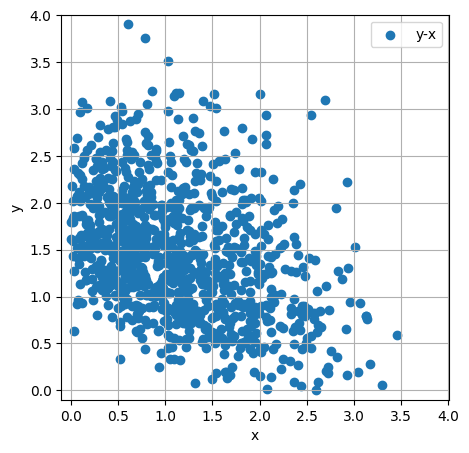

In [22]:
def getLinearRanker(K):
    def linearRanker(data):
        return data @ K
    return linearRanker
K, N, B, D = np.array([a, b]), 1000, 5, 2
rst = max_gaussian_sampler(getLinearRanker(K), N, B, D)
plotXY(rst[:, 0], rst[:, 1])

Text(0, 0.5, '$y$')

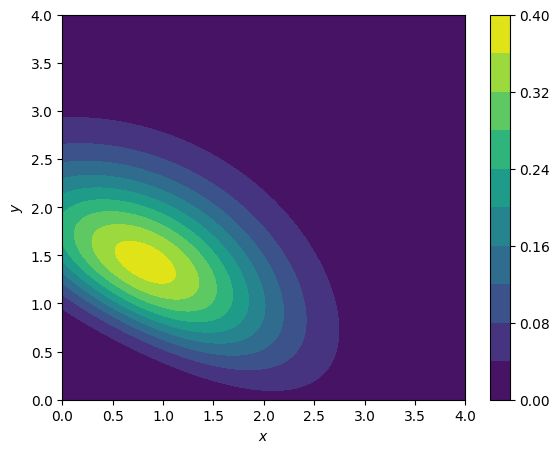

In [24]:
plt.rcParams['figure.figsize'] = 6.5, 5
plt.contourf(X, Y, pnxy, 10)
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')